In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

import tensorflow as tf

import os
import pickle
import numpy as np

print(tf.__version__)
print(keras.__version__)

1.1.0
2.0.8


In [70]:
num_examples_per_class = 10000

classes = ['aircraft carrier','airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe','banana',
           'bandage','barn','baseball bat','baseball','basket','basketball','bathtub','beach','bear','beard',
           'bed','bee','belt','bicycle','binoculars','birthday cake','blueberry','book','boomerang','bottlecap',
           'bowtie','bracelet','brain','bread','broom','bulldozer','bus','bush','butterfly','cactus',
           'cake','calculator','calendar','camel','camera','campfire','candle','cannon','canoe','car',
           'carrot','cello','computer','cat','chandelier','clock','cloud','coffee cup','compass','cookie',
           'couch','cow','crab','crayon','crocodile','crown','cup','diamond','dog','dolphin',
           'donut','dragon','dresser','drill','drums','duck','dumbbell','ear','elbow','elephant',
           'envelope','eraser','eye','eyeglasses','face','fan','feather','fence','finger','fire hydrant',
           'fireplace','firetruck','fish','flamingo','flashlight','flip flops','floor lamp','flower','flying saucer','foot',
           'fork','frog','frying pan','garden hose','garden','giraffe','goatee','golf club','grapes','grass',
           'guitar','hamburger','hammer','hand','harp','hat','headphones','hedgehog','helicopter','helmet',
           'hexagon','hockey puck','hockey stick','horse','hospital','hot air balloon','hot dog','hot tub','hourglass','house plant',
           'house','hurricane','ice cream','jacket','jail','kangaroo','key','keyboard','knee','knife',
           'ladder','lantern','laptop','leaf','leg','light bulb','lighter','lighthouse','lightning','line',
           'lion','lipstick','lobster','lollipop','mailbox','map','marker','matches','megaphone','mermaid',
           'microphone','microwave','monkey','moon','mosquito','motorbike','mountain','mouse','moustache','mouth',
           'mug','mushroom','nail','necklace','nose','ocean','octagon','octopus','onion','oven',
           'owl','paint can','paintbrush','palm tree','panda','pants','paper clip','parachute','parrot','passport',
           'peanut','pear','peas','pencil','penguin','piano','pickup truck','picture frame','pig','pillow']

num_classes = len(classes)

print(num_classes)

200


## Load the dataset

In [71]:
# Load data here
x_data = np.load("./data/quickdraw/x_data_200_classes_10k.npy")

x_data = x_data.reshape(x_data.shape[0], 28, 28, 1)
x_data = x_data.astype('float32')
x_data /= 255

print(x_data.shape)

labels = [np.full((num_examples_per_class,), classes.index(qdraw)) for qdraw in classes]

# Concat the arrays together
y_data = np.concatenate(labels)
y_data = keras.utils.to_categorical(y_data, num_classes)

print(y_data.shape)

# Reduce data size
x_data = np.concatenate([x_data[i:i + 1000] for i in range(0, len(x_data), num_examples_per_class)])
y_data = np.concatenate([y_data[i:i + 1000] for i in range(0, len(y_data), num_examples_per_class)])

print(x_data.shape)
print(y_data.shape)

# Partition data into training set and validation set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(2000000, 28, 28, 1)
(2000000, 200)
(200000, 28, 28, 1)
(200000, 200)


In [72]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

## Define the Model

In [75]:
Inp = Input(shape=(28, 28, 1))

# Convolution block 1
x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='Conv_01')(Inp)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='Conv_02')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), name='MaxPool_01')(x)
x = Dropout(0.25, name='Dropout_01')(x)

# Convolution block 2
x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='Conv_03')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='Conv_04')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), name='MaxPool_02')(x)
x = Dropout(0.5, name='Dropout_02')(x)

x = Flatten(name='Flatten_01')(x)
x = Dense(256, activation='relu', name='Dense_01')(x)
x = Dropout(0.5, name='Dropout_03')(x)
output = Dense(num_classes, activation='softmax', name='Dense_02')(x)

# Define model inputs and output
model = Model(Inp, output)
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
Conv_02 (Conv2D)             (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 12, 12, 32)        0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 12, 12, 32)        0         
__________

## Train the model

In [76]:
batch_size = 128
epochs = 10

# Fit the model on the batches generated by datagen.flow().
hist = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Epoch 1/10
1250/1250 [==============================] - 113s - loss: 4.6200 - acc: 0.0653 - val_loss: 3.2374 - val_acc: 0.2795
Epoch 2/10
1250/1250 [==============================] - 110s - loss: 3.5761 - acc: 0.2030 - val_loss: 2.5001 - val_acc: 0.4189
Epoch 3/10
1250/1250 [==============================] - 109s - loss: 3.1189 - acc: 0.2815 - val_loss: 2.2904 - val_acc: 0.4605
Epoch 4/10
1250/1250 [==============================] - 109s - loss: 2.8826 - acc: 0.3269 - val_loss: 2.0593 - val_acc: 0.5088
Epoch 5/10
1250/1250 [==============================] - 109s - loss: 2.7249 - acc: 0.3571 - val_loss: 1.9624 - val_acc: 0.5340
Epoch 6/10
1250/1250 [==============================] - 109s - loss: 2.6189 - acc: 0.3805 - val_loss: 1.9013 - val_acc: 0.5472
Epoch 7/10
1250/1250 [==============================] - 109s - loss: 2.5385 - acc: 0.3955 - val_loss: 1.8211 - val_acc: 0.5585
Epoch 8/10
1250/1250 [==============================] - 111s - loss: 2.4771 - acc: 0.4077 - val_loss: 1.7702 - 

## Evaluate the model

In [77]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
                                                   batch_size=batch_size,
                                                   shuffle=False),
                                      steps=x_test.shape[0] // batch_size,
                                      workers=4)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

Model Accuracy = 0.53
Model Loss = 1.96


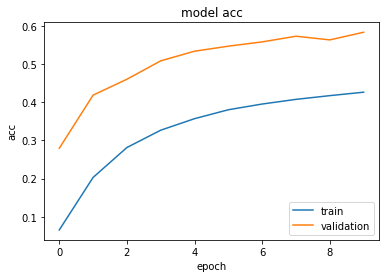

In [78]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    
plot_train(hist)

## Make predictions with the model


In [79]:
def show_image(data):
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(data.reshape(28, 28), cmap='gray_r')
    plt.show()

In [80]:
predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
                                                   batch_size=batch_size,
                                                   shuffle=False),
                                      steps=x_test.shape[0] // batch_size,
                                      workers=4)

Actual Label = carrot vs. Predicted Label = cello


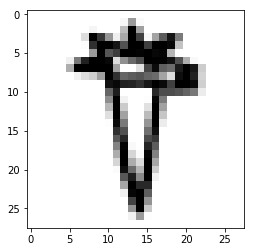

Actual Label = dumbbell vs. Predicted Label = oven


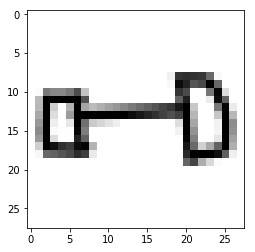

Actual Label = mouse vs. Predicted Label = bathtub


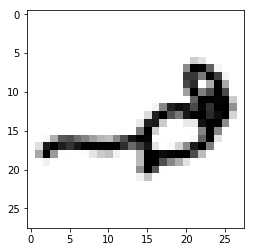

Actual Label = elephant vs. Predicted Label = parachute


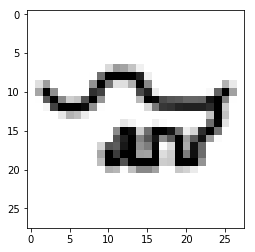

Actual Label = horse vs. Predicted Label = apple


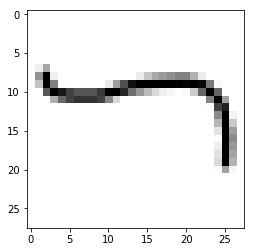

Actual Label = crab vs. Predicted Label = hockey stick


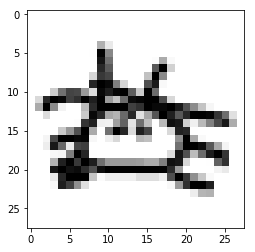

Actual Label = book vs. Predicted Label = hurricane


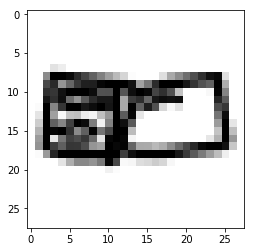

Actual Label = bicycle vs. Predicted Label = car


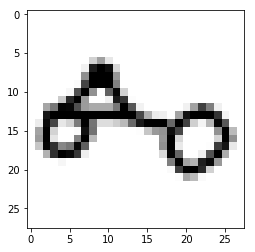

Actual Label = bed vs. Predicted Label = beach


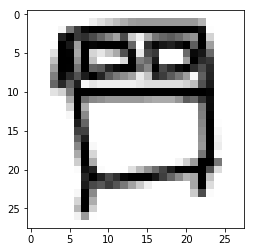

Actual Label = computer vs. Predicted Label = ice cream


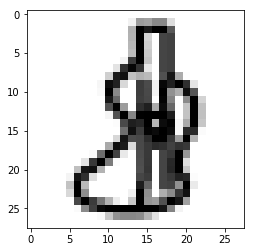

Actual Label = octopus vs. Predicted Label = boomerang


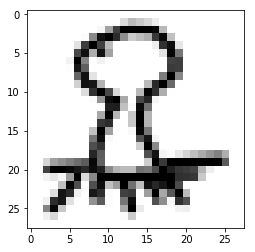

Actual Label = paper clip vs. Predicted Label = panda


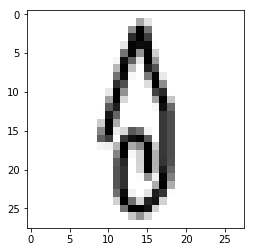

Actual Label = mermaid vs. Predicted Label = peas


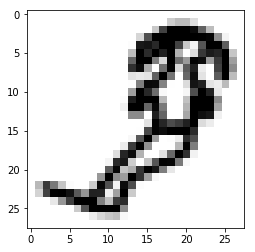

Actual Label = kangaroo vs. Predicted Label = lighthouse


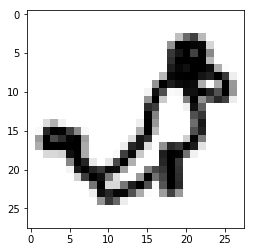

Actual Label = eraser vs. Predicted Label = helicopter


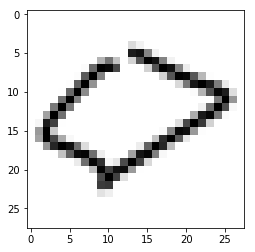

Actual Label = hammer vs. Predicted Label = octopus


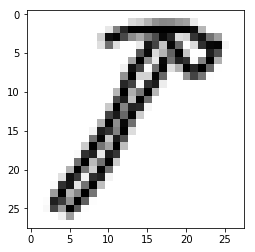

Actual Label = chandelier vs. Predicted Label = aircraft carrier


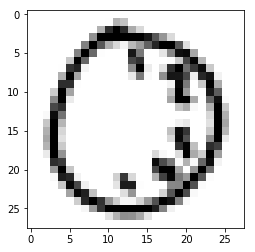

Actual Label = baseball bat vs. Predicted Label = headphones


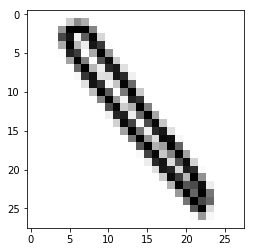

Actual Label = clock vs. Predicted Label = flashlight


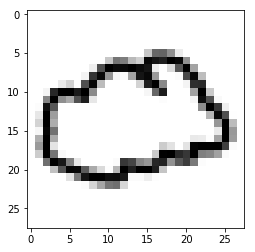

Actual Label = matches vs. Predicted Label = bush


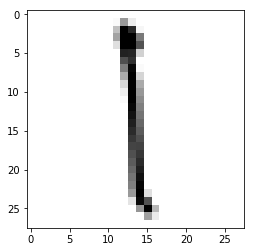

Actual Label = beard vs. Predicted Label = matches


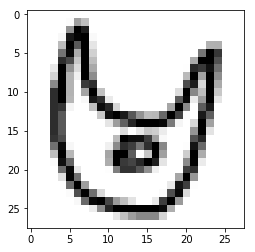

In [81]:
num_predictions = 20

predict_gen = predict_gen[num_predictions:]

for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = classes[np.argmax(y_test[predict_index])]
    predicted_label = classes[np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    show_image(x_test[predict_index])
    if predict_index == num_predictions:
        break

## Save the model

In [82]:
model.save('project02.h5')